# Regional means

This notebook should demonstrate how CORDEX datasets can be used for looking at regional and local scales. This often involves masking and averaging over a limited area of the dataset, e.g., a country or city.

In [1]:
import os
import xarray as xr
import numpy as np
import cf_xarray as cfxr
import pyesgf
from pyesgf.logon import LogonManager
from pyesgf.search import SearchConnection

lm = LogonManager(verify=True)

if not lm.is_logged_on():
    myproxy_host = "esgf-data.dkrz.de"
    # if we find those in environment, use them.
    if "ESGF_USER" in os.environ and "ESGF_PASSWORD" in os.environ:
        lm.logon(
            hostname=myproxy_host,
            username=os.environ["ESGF_USER"],
            password=os.environ["ESGF_PASSWORD"],
            interactive=False,
            bootstrap=True,
        )
    else:
        lm.logon(
            hostname=myproxy_host,
            interactive=True,
            bootstrap=True,
        )

print(f"logged on: {lm.is_logged_on()}")

logged on: True


In [2]:
hist_urls = [
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_195001-195012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_195101-196012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_196101-197012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_197101-198012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_198101-199012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_199101-200012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/historical/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_historical_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_200101-200512.nc",
]


rcp85_urls = [
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_200601-201012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_201101-202012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_202101-203012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_203101-204012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_204101-205012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_205101-206012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_206101-207012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_207101-208012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_208101-209012.nc",
    "http://esgf1.dkrz.de/thredds/dodsC/cordex-reklies/output/EUR-11/CLMcom/MIROC-MIROC5/rcp85/r1i1p1/CLMcom-CCLM4-8-17/v1/mon/tas/v20171121/tas_EUR-11_MIROC-MIROC5_rcp85_r1i1p1_CLMcom-CCLM4-8-17_v1_mon_209101-210012.nc",
]

In [3]:
ds = xr.open_mfdataset(
    hist_urls + rcp85_urls,
    chunks={},
    parallel=False,
    combine="by_coords",
    data_vars="minimal",
    coords="minimal",
    compat="override",
)

We are interested in looking at the change in the temperature with respect to the reference period from 1981 to 2010.

In [4]:
ds_change = ds.drop("time_bnds").copy()
ds_change["tas"] = ds_change.tas - ds_change.tas.sel(time=slice("1981", "2010")).mean(
    "time"
)

In [5]:
ds_change

<xarray.Dataset>
Dimensions:       (rlon: 424, rlat: 412, time: 1812, vertices: 4)
Coordinates:
  * rlon          (rlon) float64 -28.38 -28.26 -28.16 ... 17.93 18.05 18.16
  * rlat          (rlat) float64 -23.38 -23.26 -23.16 ... 21.61 21.73 21.83
  * time          (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00
    height        float64 ...
    lat           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(412, 424), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    rotated_pole  |S64 ...
    lon_vertices  (rlat, rlon, vertices) float64 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    lat_vertices  (rlat, rlon, vertices) float64 dask.array<chunksize=(412, 424, 4), meta=np.ndarray>
    tas           (time, rlat, rlon) float32 dask.array<chunksize=(12, 412, 424), meta=np.ndarray>
Attributes: (12/25)
    contact:                         klima.projektionen@dwd.de
    CORDEX_domain:                   EUR-11
    institute_id:                    CLMcom
    institution:                     CLMcom, Climate Limited-area Modelling C...
    driving_model_id:                MIROC-MIROC5
    driving_experiment_name:         historical
    ...                              ...
    product:                         output
    frequency:                       mon
    tracking_id:                     f8f42fcc-de80-11e7-946e-8fbd619ea293
    creation_date:                   2017-12-11T15:38:37Z
    DODS.strlen:                     0
    DODS_EXTRA.Unlimited_Dimension:  time

Define a plotting function

In [31]:
def plot(
    da,
    transform=ccrs.PlateCarree(),
    projection=ccrs.PlateCarree(),
    vmin=None,
    vmax=None,
    cmap=None,
    borders=True,
    xlocs=range(-180, 180, 2),
    ylocs=range(-90, 90, 2),
    extent=None,
    figsize=(15, 10),
    title=None,
):
    """plot a domain using the right projections and transformations with cartopy"""
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)
    ax = plt.axes(projection=projection)
    if extent:
        # ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
        ax.set_extent(extent, crs=projection)
    ax.gridlines(
        draw_labels=True, linewidth=0.5, color="gray", xlocs=xlocs, ylocs=ylocs
    )
    da.plot(ax=ax, cmap=cmap, transform=transform, vmin=vmin, vmax=vmax)
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    if borders:
        ax.add_feature(cf.BORDERS)
    if title is not None:
        ax.set_title(title)

## Masking with `regionmask`

In [6]:
import regionmask

In [7]:
prudence = regionmask.defined_regions.prudence
prudence

<regionmask.Regions>
Name:     PRUDENCE
Source:   Christensen and Christensen, 2007, Climatic Change 81:7-30 (https:/...
overlap:  True

Regions:
1 BI     British Isles
2 IP Iberian Peninsula
3 FR            France
4 ME        Mid-Europe
5 SC       Scandinavia
6 AL              Alps
7 MD     Mediterranean
8 EA    Eastern Europe

[8 regions]

Let's have a look at those regions:

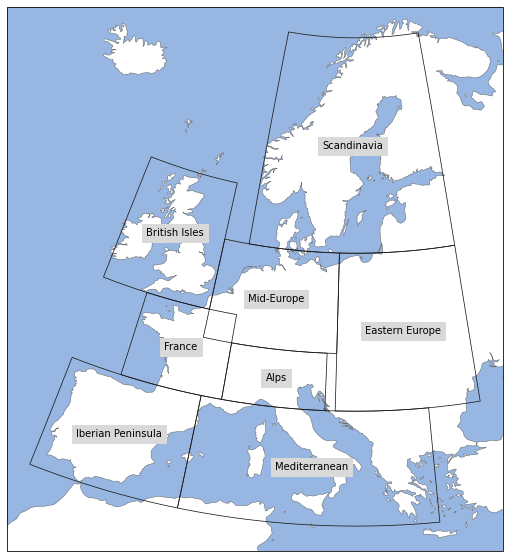

In [10]:
import matplotlib.pyplot as plt
from cartopy import crs as ccrs

plt.rcParams["figure.figsize"] = (20, 10)
pole = (
    ds.rotated_pole.grid_north_pole_longitude,
    ds.rotated_pole.grid_north_pole_latitude,
)
proj = ccrs.RotatedPole(*pole)
ax = prudence.plot(
    add_ocean=True,
    projection=proj,
    resolution="50m",
    label="name",
    line_kws=dict(lw=0.75),
)

Create a mask for each region that fits our dataset coordinates.

In [11]:
mask_prudence = prudence.mask_3D(ds.lon, ds.lat)

We can now use the mask to only look at a certain region, e.g.

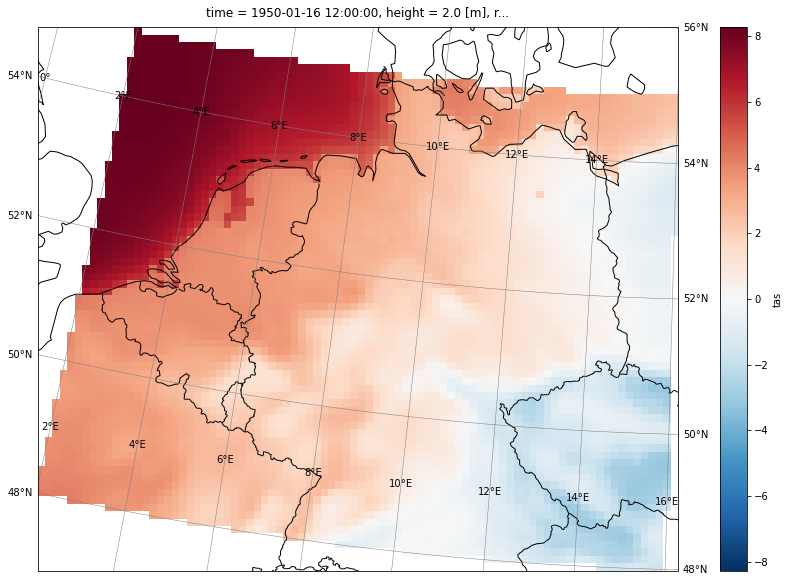

In [32]:
me_tas = ds.tas.isel(time=0).where(
    mask_prudence.isel(region=(mask_prudence.names == "Mid-Europe")).squeeze(),
    drop=True,
)
plot(
    me_tas - 273.5,
    transform=ccrs.RotatedPole(*pole),
    projection=ccrs.RotatedPole(*pole),
)

Let's compute a spatial average over each region to compare the changes between them

In [33]:
weights = np.cos(np.deg2rad(ds.rlat))
tas_change_regional = ds_change.tas.weighted(mask_prudence * weights).mean(
    dim=("rlat", "rlon")
)

The computation so far was done [lazily](https://docs.xarray.dev/en/stable/user-guide/dask.html). Before plotting, we will explictly trigger the compuation here.

In [39]:
%%time
from dask.diagnostics import ProgressBar

with ProgressBar():
    tas_change_regional_ = tas_change_regional.compute()

[########################################] | 100% Completed |  8.5s
CPU times: user 17.4 s, sys: 2.57 s, total: 19.9 s
Wall time: 8.51 s


Let's look at the change in yearly means for each region! We will use a rolling mean over the climatic timescale of 30 years.

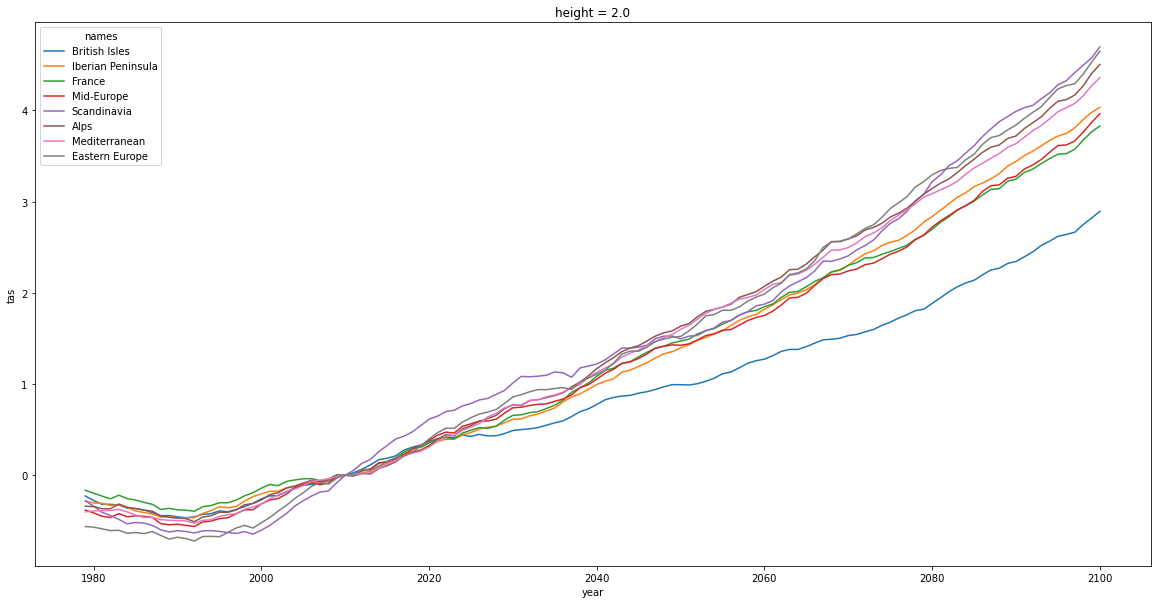

In [60]:
tas_change_regional_.groupby("time.year").mean("time").rolling(
    year=30
).mean().swap_dims({"region": "names"}).plot(hue="names")

In [37]:
def get_grid(domain):
    """create cordex grid with bounds

    workaround for https://github.com/xarray-contrib/cf-xarray/issues/360

    """
    ds = cx.cordex_domain(domain, add_vertices=True)
    ds = ds.assign(
        lon_b=cfxr.bounds_to_vertices(ds.lon_vertices, "vertices"),
        lat_b=cfxr.bounds_to_vertices(ds.lat_vertices, "vertices"),
    ).drop(("lon_vertices", "lat_vertices"))
    ds.lon.attrs["bounds"] = "lon_b"
    ds.lat.attrs["bounds"] = "lat_b"
    return ds


def get_averager(grid, gdf):
    """create spatial averager for a grid file"""
    return xe.SpatialAverager(grid, gdf.geometry, geom_dim_name="region")